Mushi
==
_All that the rain promises and more..._

A notebook for testing `mushi`'s ability to invert data simulated under the forward model

API documentation can be viewed with
```python
help(PiecewiseConstantHistory)
help(JointHistory)
help(SFS)
```

In [4]:
%matplotlib notebook
import mushi
from mushi import PiecewiseConstantHistory, JointHistory, SFS
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import expit
import time

### Time grid

In [5]:
t = np.logspace(0, 4, 200)

### Demographic history $\eta(t)$

<IPython.core.display.Javascript object>


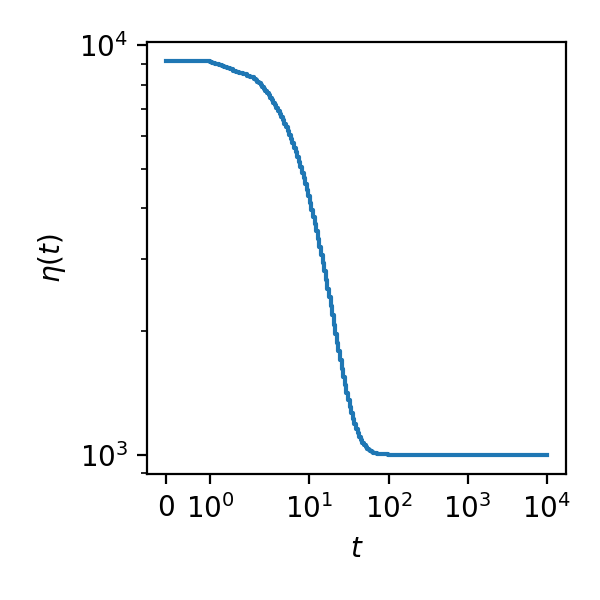

In [12]:
y = 1000 * np.ones(len(t) + 1)
y[:-1] += 9000 * np.exp(- .1 * t)
η = PiecewiseConstantHistory(t, y)

plt.figure(figsize=(3, 3))
η.plot()
plt.xlabel('$t$')
plt.ylabel('$η(t)$')
plt.xscale('symlog')
plt.yscale('log')
plt.tight_layout()
plt.show()

### Mutation rate history $\mu(t)$

<IPython.core.display.Javascript object>


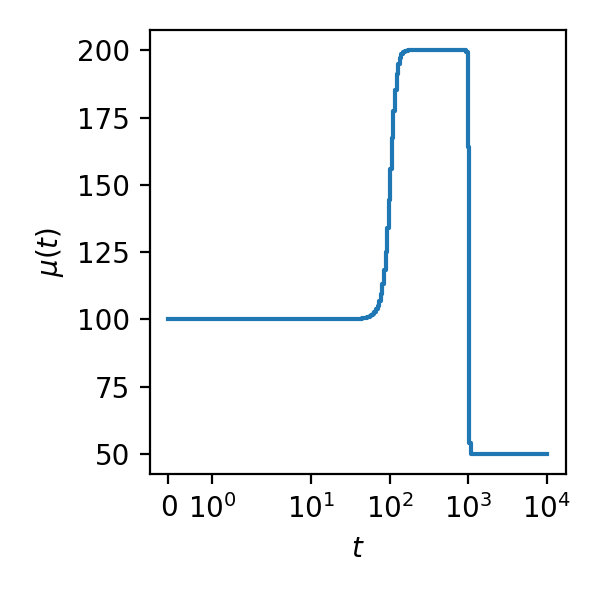

In [13]:
z = np.ones(len(t) + 1)
z[1:] += expit(.1 * (t - 100)) - 1.5 * expit(.1 * (t - 1000))
# z[:-1] += 1 * np.exp(- .1 * t)
μ = PiecewiseConstantHistory(t, 100 * z)

plt.figure(figsize=(3, 3))
μ.plot()
plt.xlabel('$t$')
plt.ylabel('$μ(t)$')
plt.xscale('symlog')
plt.tight_layout()
plt.show()

Number of haplotypes we'll sample under this history

In [18]:
n = 200
history = JointHistory(η, μ)

### TMRCA CDF

<IPython.core.display.Javascript object>


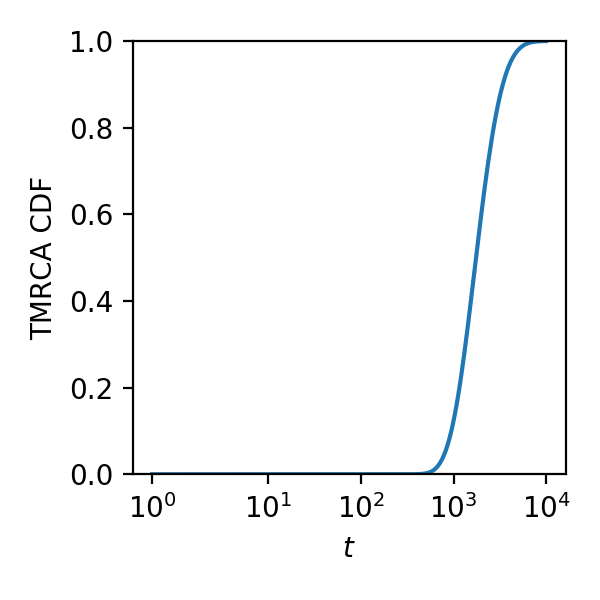

In [19]:
plt.figure(figsize=(3, 3))
plt.plot(η.change_points, mushi.SFS(n).tmrca_cdf(history.η))
plt.xlabel('$t$'); plt.ylabel('TMRCA CDF'); plt.ylim([0, 1]); plt.xscale('symlog')
plt.tight_layout()
plt.show()

### Simulate a SFS under this history
Plot the SFS and the CDF of the TMRCA of the sample

<IPython.core.display.Javascript object>


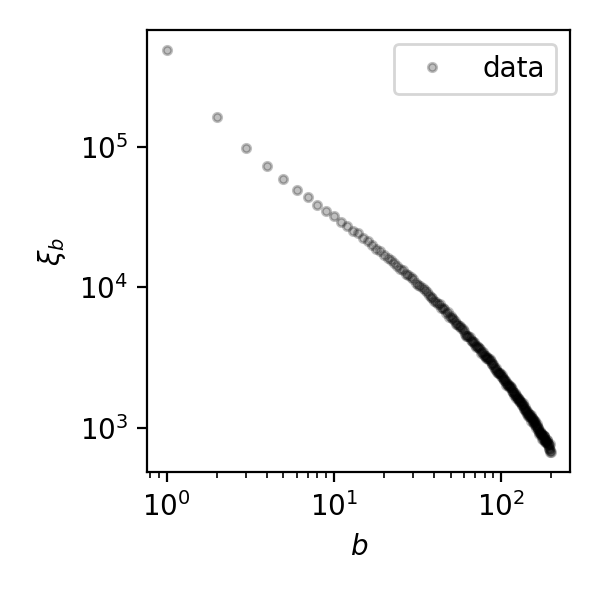

In [21]:
sfs = SFS(n)
sfs.simulate(history, seed=1)

plt.figure(figsize=(3, 3))
sfs.plot()
plt.tight_layout()
plt.show()

### Invert the SFS conditioned on $\eta(t)$ to get $\mu(t)$

In [24]:
λ = 1e0
α = 0.99
s = 1e-1
steps = 20000
μ_inferred = sfs.infer_μ(η, λ=λ, α=α, s=s, steps=steps)
history_inferred = JointHistory(η, μ_inferred)

<IPython.core.display.Javascript object>


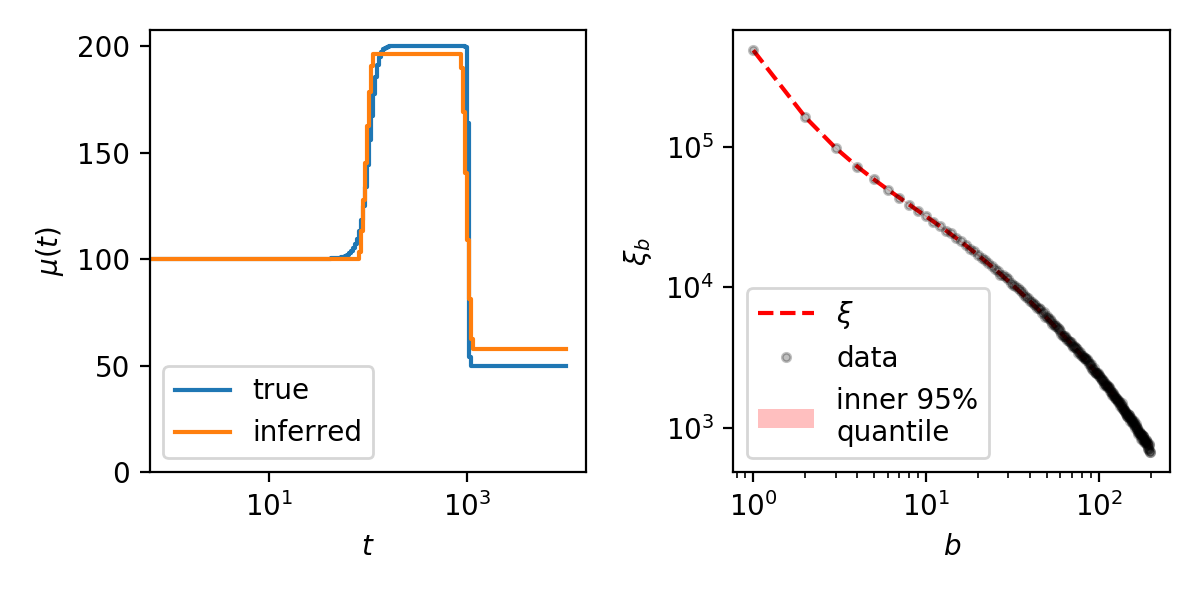

In [25]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
history.μ.plot(label='true')
history_inferred.μ.plot(label='inferred')
plt.xlabel('$t$')
plt.ylabel('$μ(t)$')
plt.xscale('log')
plt.ylim((0, None))

plt.subplot(1, 2, 2)
sfs.plot(history_inferred,
         prf_quantiles=True
        )
plt.tight_layout()
plt.show()